# DenseNet121 + SE Block

##  SE-DenseNet121 Definition & Evaluation Setup

This section defines an enhanced DenseNet121 architecture integrated with Squeeze-and-Excitation (SE) blocks, aiming to improve channel-wise feature recalibration. It sets up the evaluation function, device configuration, and prepares multiple data augmentation strategies (`minimal`, `default`, `extensive`) for training. The model's performance on validation data will be tracked to identify the globally best configuration.

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os, sys

# Add parent directory to sys.path to enable importing local modules
sys.path.append(os.path.abspath(".."))
from dataset import create_dataloaders

# Define the Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.BatchNorm1d(channel // reduction),
            nn.SiLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Wrap DenseNet121 with SE blocks
def densenet121_se(num_classes, reduction=8):

    # Load pre-trained DenseNet
    base = densenet121(weights=DenseNet121_Weights.DEFAULT)
    feat = base.features 
    cls_layer = base.classifier
    class Net(nn.Module):
        def __init__(self):
            super().__init__()

            # Extract stem and blocks from DenseNet
            self.stem = nn.Sequential(*list(feat.children())[:4])
            self.block1, self.trans1 = feat.denseblock1, feat.transition1
            self.block2, self.trans2 = feat.denseblock2, feat.transition2
            self.block3, self.trans3 = feat.denseblock3, feat.transition3
            self.block4 = feat.denseblock4; self.norm5 = feat.norm5

            # Add SE blocks after each dense block
            self.se1 = SEBlock(256, reduction)
            self.se2 = SEBlock(512, reduction)
            self.se3 = SEBlock(1024, reduction)
            self.se4 = SEBlock(1024, reduction)

            # Replace original classifier
            self.classifier = nn.Linear(1024, num_classes)

        def forward(self, x):
            x = self.stem(x)
            x = self.block1(x); x = self.se1(x); x = self.trans1(x)
            x = self.block2(x); x = self.se2(x); x = self.trans2(x)
            x = self.block3(x); x = self.se3(x); x = self.trans3(x)
            x = self.block4(x); x = self.se4(x)
            x = self.norm5(x)
            x = nn.functional.adaptive_avg_pool2d(x, (1,1)).view(x.size(0),-1)
            return self.classifier(x)
    return Net()

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Evaluation function to compute accuracy over a dataset
def evaluate_accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1)
            correct += (preds==lbls).sum().item()
            total += lbls.size(0)
    return correct/total

# Define enhancement strategy names
strategies = ['minimal','default','extensive']
all_class_names = None

# Global variables to keep track of best model and strategy
global_best_acc = 0.0
global_best_state = None
global_best_strategy = None

Using device: cuda


##  Train SE-DenseNet121 with Augmentation Strategies

This section trains a DenseNet121 model enhanced with Squeeze-and-Excitation (SE) blocks across three augmentation strategies: `minimal`, `default`, and `extensive`. For each strategy, the model is trained for 10 epochs with performance tracking and visualization. The model with the highest validation accuracy is saved as the best SE-based model.


=== Training with minimal ===
Epoch 1/10 | Loss: 99.8484 | Train Acc: 0.8853 | Val Acc: 0.9354 | Val Loss: 16.0957
Epoch 2/10 | Loss: 22.5123 | Train Acc: 0.9731 | Val Acc: 0.9354 | Val Loss: 16.6989
Epoch 3/10 | Loss: 13.2406 | Train Acc: 0.9843 | Val Acc: 0.9367 | Val Loss: 14.4285
Epoch 4/10 | Loss: 7.6270 | Train Acc: 0.9904 | Val Acc: 0.9463 | Val Loss: 13.0071
Epoch 5/10 | Loss: 6.1798 | Train Acc: 0.9922 | Val Acc: 0.9508 | Val Loss: 11.8968
Epoch 6/10 | Loss: 3.7724 | Train Acc: 0.9964 | Val Acc: 0.9621 | Val Loss: 10.3585
Epoch 7/10 | Loss: 1.9002 | Train Acc: 0.9985 | Val Acc: 0.9604 | Val Loss: 9.7309
Epoch 8/10 | Loss: 1.8031 | Train Acc: 0.9982 | Val Acc: 0.9608 | Val Loss: 10.0107
Epoch 9/10 | Loss: 2.3130 | Train Acc: 0.9972 | Val Acc: 0.9637 | Val Loss: 9.8220
Epoch 10/10 | Loss: 1.6115 | Train Acc: 0.9983 | Val Acc: 0.9633 | Val Loss: 9.7746


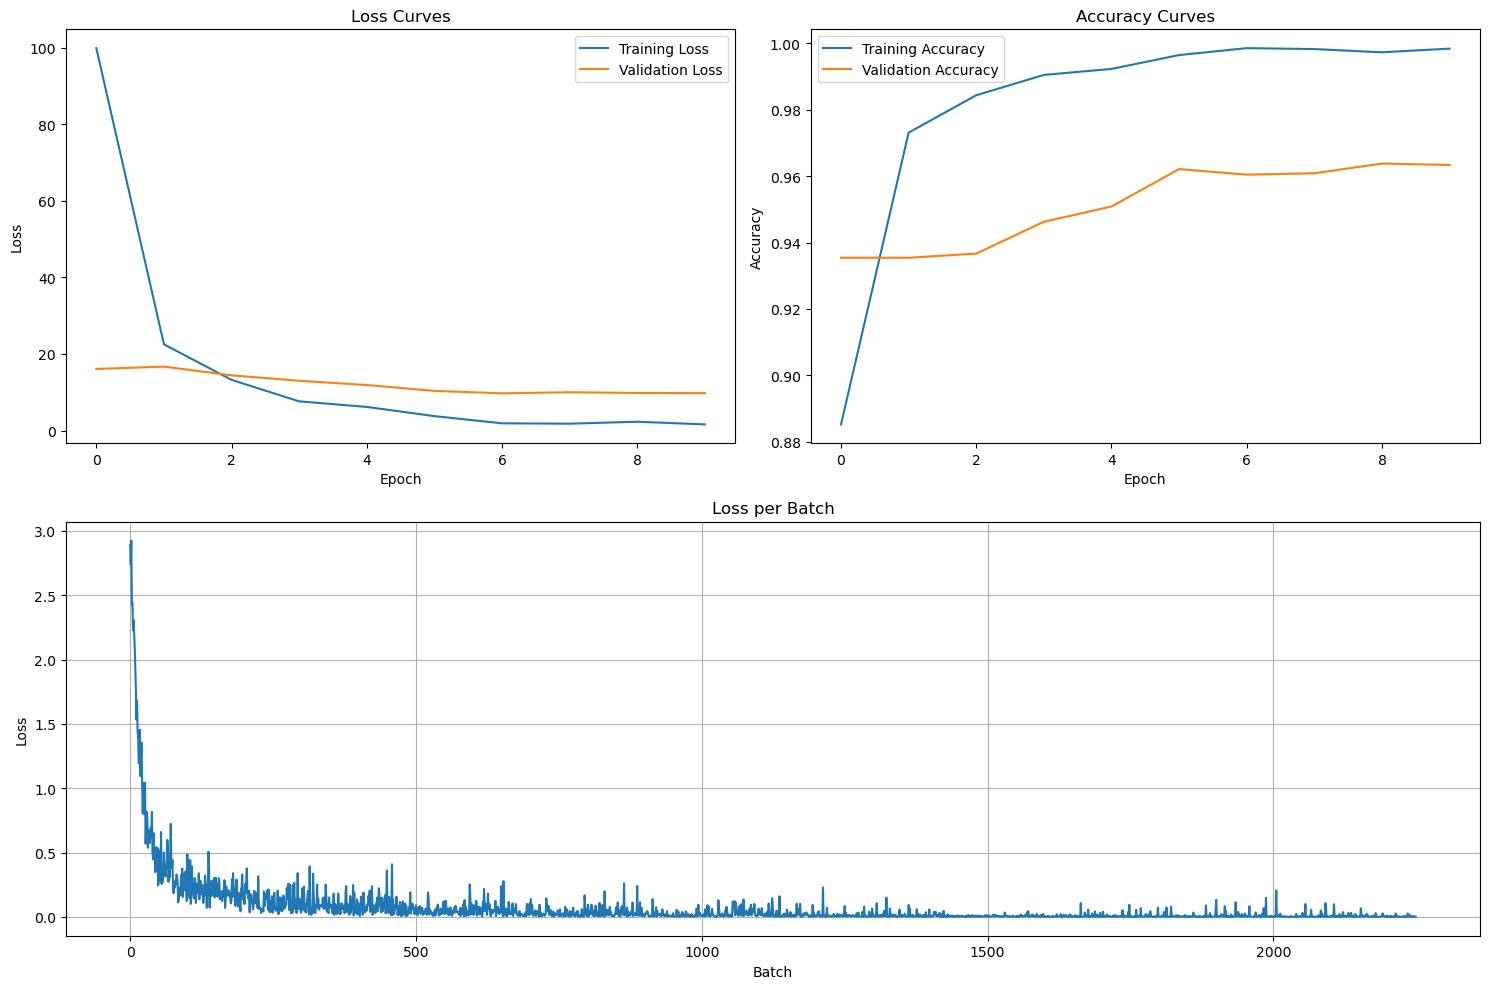


=== Training with default ===
Epoch 1/10 | Loss: 153.9421 | Train Acc: 0.7967 | Val Acc: 0.8762 | Val Loss: 30.6967
Epoch 2/10 | Loss: 60.0173 | Train Acc: 0.9189 | Val Acc: 0.9000 | Val Loss: 22.8287
Epoch 3/10 | Loss: 48.2554 | Train Acc: 0.9283 | Val Acc: 0.9087 | Val Loss: 21.6928
Epoch 4/10 | Loss: 39.4848 | Train Acc: 0.9429 | Val Acc: 0.9229 | Val Loss: 19.1237
Epoch 5/10 | Loss: 33.7115 | Train Acc: 0.9517 | Val Acc: 0.9313 | Val Loss: 17.4937
Epoch 6/10 | Loss: 22.3784 | Train Acc: 0.9674 | Val Acc: 0.9354 | Val Loss: 15.9461
Epoch 7/10 | Loss: 18.6573 | Train Acc: 0.9751 | Val Acc: 0.9425 | Val Loss: 14.6009
Epoch 8/10 | Loss: 17.0690 | Train Acc: 0.9754 | Val Acc: 0.9417 | Val Loss: 15.1571
Epoch 9/10 | Loss: 17.3913 | Train Acc: 0.9754 | Val Acc: 0.9471 | Val Loss: 14.9797
Epoch 10/10 | Loss: 14.5763 | Train Acc: 0.9800 | Val Acc: 0.9433 | Val Loss: 14.9642


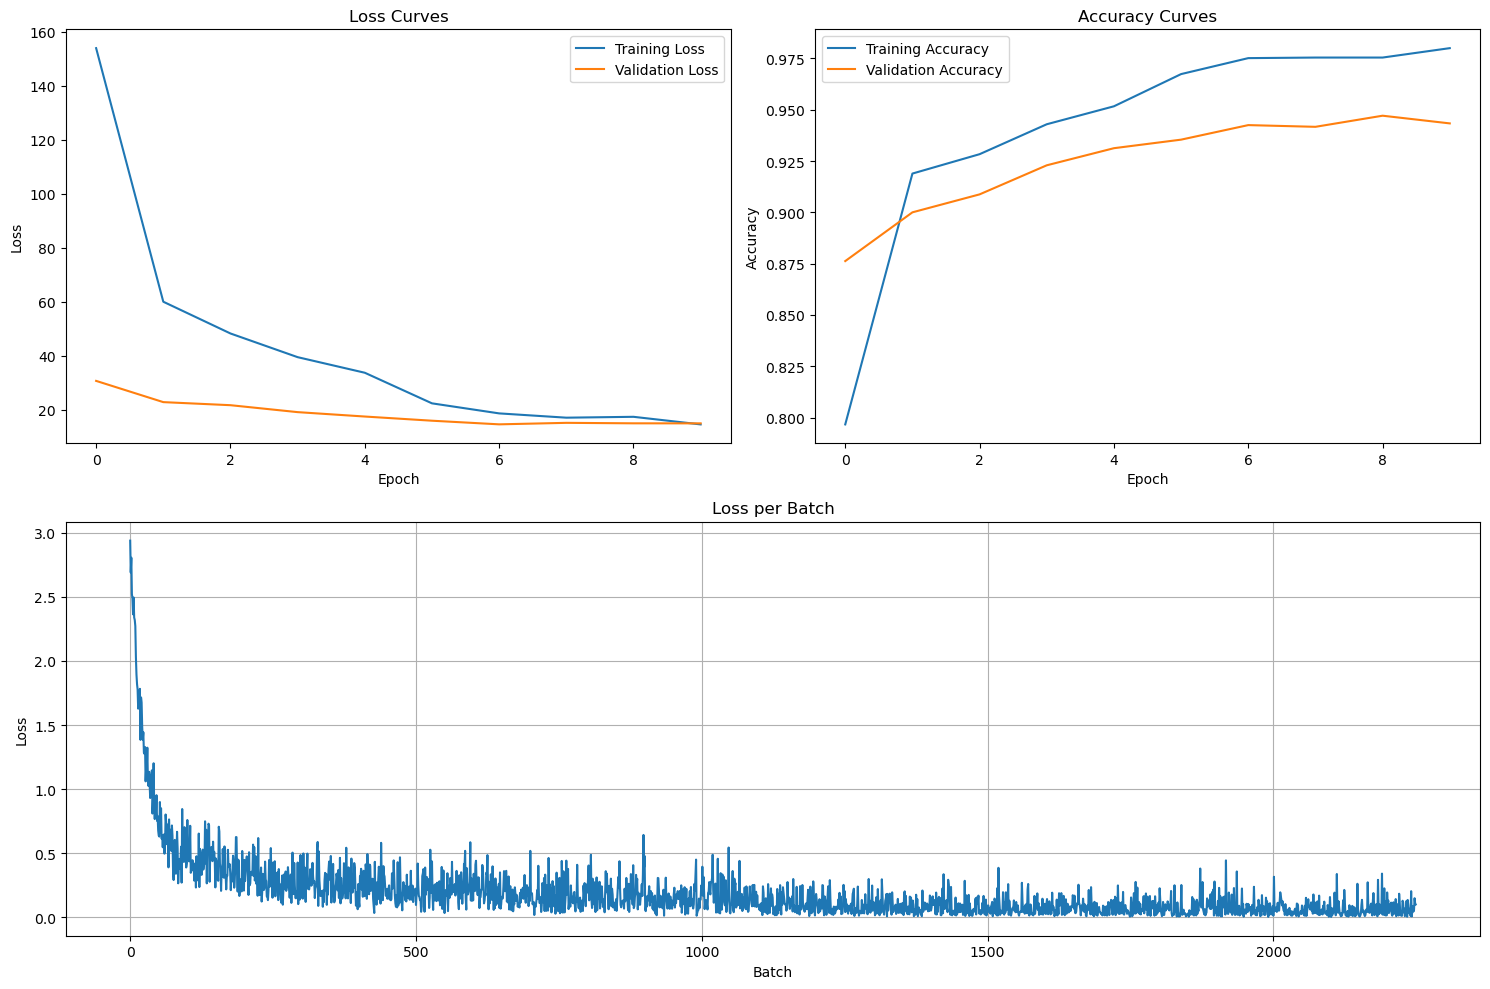


=== Training with extensive ===
Epoch 1/10 | Loss: 188.8212 | Train Acc: 0.7517 | Val Acc: 0.8292 | Val Loss: 41.7577
Epoch 2/10 | Loss: 91.0574 | Train Acc: 0.8758 | Val Acc: 0.8633 | Val Loss: 33.9061
Epoch 3/10 | Loss: 78.7387 | Train Acc: 0.8874 | Val Acc: 0.8475 | Val Loss: 37.7702
Epoch 4/10 | Loss: 64.8834 | Train Acc: 0.9072 | Val Acc: 0.8888 | Val Loss: 26.2524
Epoch 5/10 | Loss: 52.4219 | Train Acc: 0.9249 | Val Acc: 0.9117 | Val Loss: 21.9882
Epoch 6/10 | Loss: 44.5309 | Train Acc: 0.9387 | Val Acc: 0.9133 | Val Loss: 22.1646
Epoch 7/10 | Loss: 37.6567 | Train Acc: 0.9465 | Val Acc: 0.9133 | Val Loss: 19.8858
Epoch 8/10 | Loss: 39.5261 | Train Acc: 0.9453 | Val Acc: 0.9062 | Val Loss: 23.3096
Epoch 9/10 | Loss: 35.9074 | Train Acc: 0.9507 | Val Acc: 0.9187 | Val Loss: 20.6029
Epoch 10/10 | Loss: 32.2180 | Train Acc: 0.9553 | Val Acc: 0.9204 | Val Loss: 19.4827


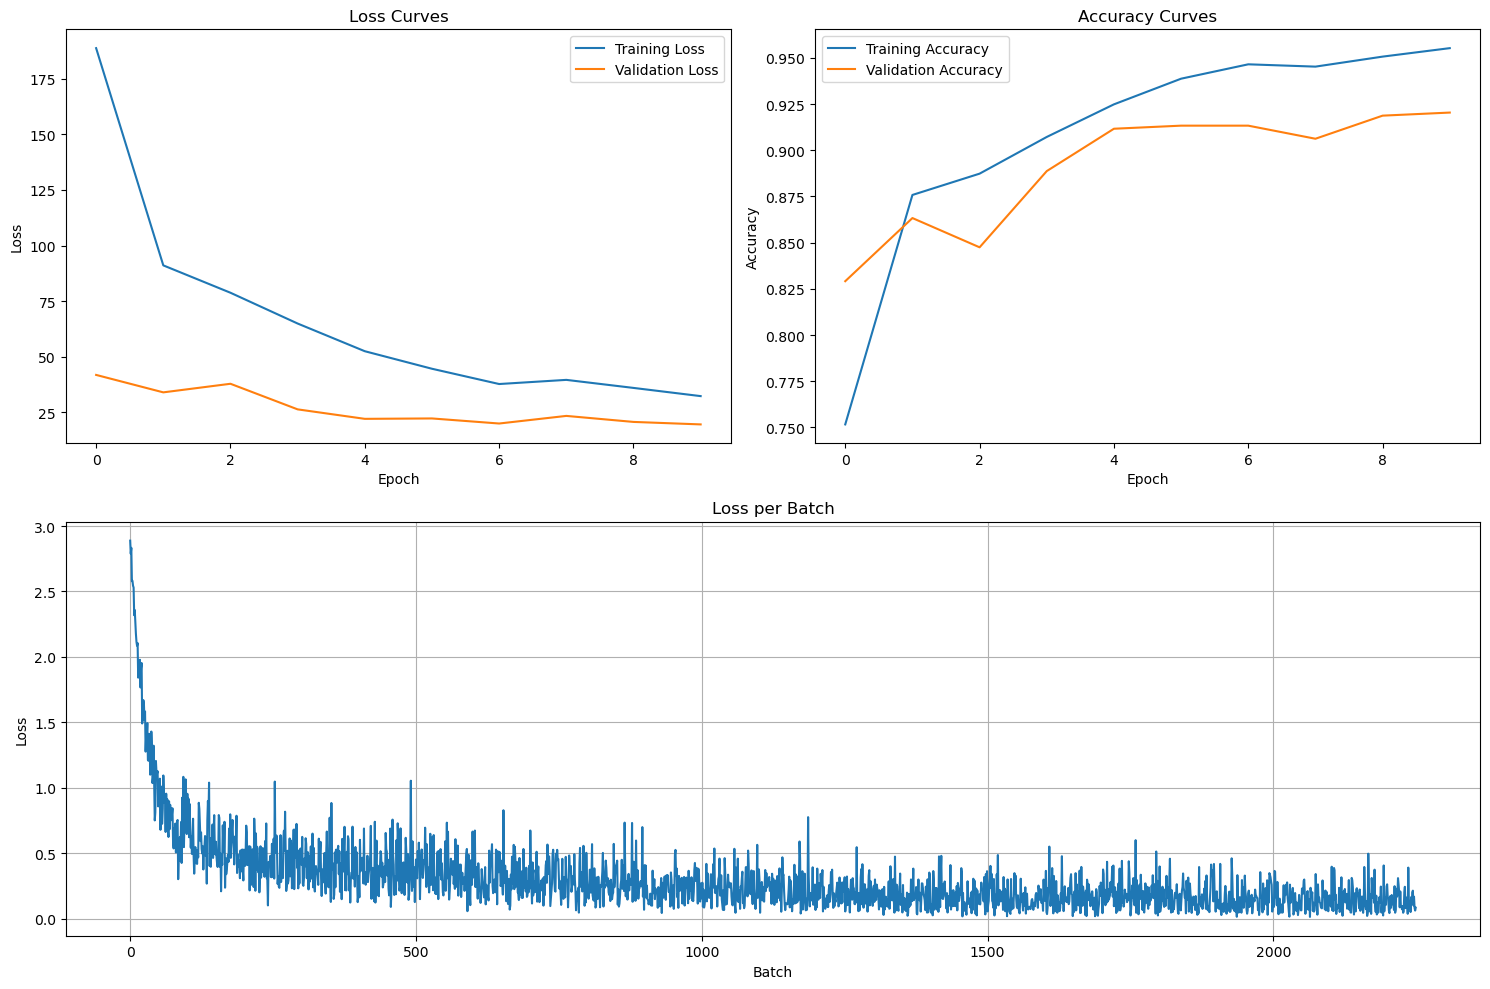

Global best: minimal @ 0.9637


In [ ]:
# Train models using three different data augmentation strategies and save the best-performing model
for strat in strategies:
    print(f"\n=== Training with {strat} ===")

    # Load training and validation dataloaders based on the current augmentation strategy
    train_loader, val_loader, _, class_names = create_dataloaders(
        root_dir=os.path.abspath(os.path.join("..","Aerial_Landscapes")),
        batch_size=32, augmentation_strategy=strat, verbose=False
    )

    # Save class names for later use
    if all_class_names is None:
        all_class_names = class_names

    # Initialize model and training components
    model = densenet121_se(num_classes=len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    best_val_acc = 0.0; best_state = None

    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'batch_losses':[]}
    
    # Train for 10 epochs
    for epoch in range(10):
        model.train()
        running_loss = 0
        corr = tot = 0

        # Training loop
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward(); 
            optimizer.step()

            # Track loss and accuracy
            history['batch_losses'].append(loss.item())
            running_loss += loss.item()
            preds = out.argmax(dim=1)
            corr += (preds==lbls).sum().item()
            tot += lbls.size(0)
        train_acc = corr/tot
        history['train_loss'].append(running_loss); 
        history['train_acc'].append(train_acc)

        # Validation loop
        model.eval()
        val_loss = corr=tot=0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                val_loss += criterion(out, lbls).item()
                preds = out.argmax(dim=1)
                corr += (preds==lbls).sum().item()
                tot += lbls.size(0)
        val_acc = corr/tot
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/10 | Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")
        
        # Save the best model for current strategy
        scheduler.step()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    # Update the global best model if current one is better
    if best_val_acc > global_best_acc:
        global_best_acc = best_val_acc
        global_best_state = best_state
        global_best_strategy = strat

    # Plot training curves for this strategy
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves'); plt.legend()

    plt.subplot(2,1,2)
    plt.plot(range(len(history['batch_losses'])), history['batch_losses'])
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss per Batch')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Save the global best model to disk
os.makedirs("saved_models_se", exist_ok=True)
torch.save(global_best_state, f"saved_models_se/best_se.pth")
print(f"Global best: {global_best_strategy} @ {global_best_acc:.4f}")


##  Evaluate SE-DenseNet121 on Test Set

The best-performing SE-DenseNet121 model is loaded and evaluated on the test set. This section presents a confusion matrix to visualize prediction accuracy across classes and a detailed classification report showing precision, recall, and F1-score for each category.

Loading best model from saved_models_se/best_se.pth


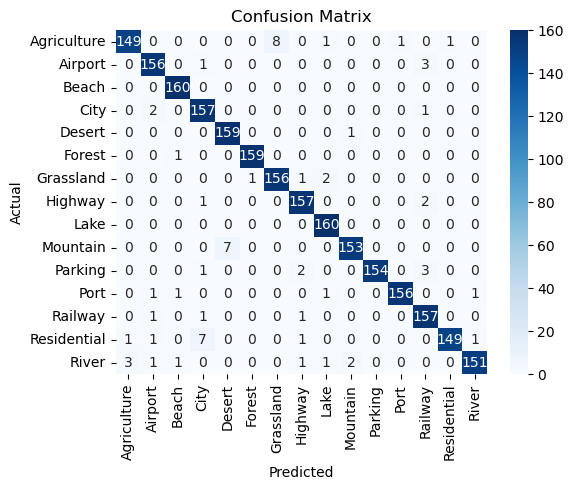


Classification Report:


,precision,recall,f1-score
Agriculture,0.974,0.931,0.952
Airport,0.963,0.975,0.969
Beach,0.982,1.000,0.991
City,0.935,0.981,0.957
Desert,0.958,0.994,0.975
Forest,0.994,0.994,0.994
Grassland,0.951,0.975,0.963
Highway,0.963,0.981,0.972
Lake,0.970,1.000,0.985
Mountain,0.981,0.956,0.968


In [ ]:
# Load the best-performing model and evaluate it on the test dataset
best_path = f"saved_models_se/best_se.pth"
print("Loading best model from", best_path)

# Load the test data loader and class labels
_, _, test_loader, class_names = create_dataloaders(
    root_dir=os.path.abspath(os.path.join("..","Aerial_Landscapes")),
    batch_size=32, verbose=False
)

# Rebuild the model architecture and load the saved weights
model = densenet121_se(num_classes=len(class_names)).to(device)
state = torch.load(best_path, map_location=device, weights_only=True)
model.load_state_dict(state)
model.eval()

# Collect ground-truth and predicted labels
y_true = []; y_pred = []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds); y_true.extend(lbls.numpy())

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Generate a classification report and format it as a DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df = pd.DataFrame(report).transpose().loc[class_names, ['precision','recall','f1-score']]

# Print the classification metrics per class with styled formatting
print(f"\nClassification Report:")
display(df.style
        .set_properties(**{'text-align':'center'})
        .format(precision=3))
